In [82]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import SpectralEmbedding
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import ward, fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook
import numpy as np
from collections import defaultdict
import unicodedata
from rapidfuzz import process
from rapidfuzz.fuzz import token_sort_ratio
from scipy.stats import wasserstein_distance
from itertools import combinations
from scipy.sparse import csr_matrix

In [3]:
# Read in the basketball-reference dataframe
df = pd.read_csv(r"C:\Users\vaugh\Desktop\basketball-pf-research\Basketball-reference data\heights_and_positions_df(2001-2024).csv")
height_df = df.drop(columns = ['Unnamed: 0', 'Pos'])

In [4]:
# Read in the basketball-reference dataframe
df = pd.read_csv(r"C:\Users\vaugh\Desktop\basketball-pf-research\Basketball-reference data\heights_and_positions_df_withMP(2001-2024).csv")
df = df.drop(columns = ['Unnamed: 0', 'Pos'])
df = df[df['Player'] != 'Team Totals']

In [6]:
merged_df = pd.merge(height_df, df, on=['Player', 'Roster'])

In [7]:
merged_df

,Player,Ht,Roster,G,MP
0,Bruce Bowen,6-7,2001MIA,82,32.7
1,Anthony Carter,6-1,2001MIA,72,22.6
2,Duane Causwell,7-0,2001MIA,31,12.4
3,Cedric Ceballos,6-7,2001MIA,27,14.6
4,Ricky Davis,6-6,2001MIA,7,10.0
...,...,...,...,...,...
13205,Nick Smith Jr.,6-2,2024CHO,51,14.3
13206,JT Thor,6-10,2024CHO,63,12.4
13207,P.J. Washington,6-7,2024CHO,44,29.2
13208,Grant Williams,6-6,2024CHO,29,30.6


In [8]:
nba_teams = {
    'Miami Heat': 'MIA',
    'Chicago Bulls': 'CHI',
    'Philadelphia 76ers': 'PHI',
    'New Jersey Nets': 'NJN',
    'Golden State Warriors': 'GSW',
    'Boston Celtics': 'BOS',
    'Indiana Pacers': 'IND',
    'Atlanta Hawks': 'ATL',
    'New York Knicks': 'NYK',
    'Toronto Raptors': 'TOR',
    'Cleveland Cavaliers': 'CLE',
    'Orlando Magic': 'ORL',
    'Phoenix Suns': 'PHO',
    'Denver Nuggets': 'DEN',
    'Houston Rockets': 'HOU',
    'Minnesota Timberwolves': 'MIN',
    'San Antonio Spurs': 'SAS',
    'Portland Trail Blazers': 'POR',
    'Sacramento Kings': 'SAC',
    'Charlotte Hornets': 'CHH',
    'Detroit Pistons': 'DET',
    'Dallas Mavericks': 'DAL',
    'Seattle SuperSonics': 'SEA',
    'Vancouver Grizzlies': 'VAN',
    'Los Angeles Lakers': 'LAL',
    'Los Angeles Clippers': 'LAC',
    'Utah Jazz': 'UTA',
    'Washington Wizards': 'WAS',
    'Milwaukee Bucks': 'MIL',
    'Memphis Grizzlies': 'MEM',
    'New Orleans Hornets': 'NOH',
    'New Orleans/Oklahoma City Hornets': 'NOK',
    'Oklahoma City Thunder': 'OKC',
    'Brooklyn Nets': 'BRK',
    'New Orleans Pelicans': 'NOP',
    'Charlotte Bobcats': 'CHO',
    'New Charlotte Hornets': 'CHA'
}

seasons = ['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
teams = list(nba_teams.values())

In [28]:
season_dfs = []

for season in seasons:
    season_df = merged_df[merged_df['Roster'].str.contains(season, na=False)].copy()
    season_df['Team'] = season_df['Roster'].apply(lambda roster: roster[4:])
    
    max_mp = season_df['MP'].max()
    max_gp = season_df['G'].max()
    season_df['Player Weight'] = (0.5 * (season_df['MP'] / max_mp)) + (0.5 * (season_df['G'] / max_gp))
    
    for team in teams:
        if team in season_df['Team'].values:
            team_df = season_df[season_df['Team'] == team].sort_values(by = 'Player Weight', ascending = False).head(10)
            season_dfs.append(team_df.drop(columns=['G', 'MP', 'Team', 'Player Weight']))

In [31]:
heights_df = pd.concat(season_dfs, ignore_index=True).set_index('Roster')
heights_df['Height'] = heights_df['Ht']
heights_df = heights_df.drop(columns = ['Ht'])

In [32]:
heights_df

,Player,Height
Roster,,
2001MIA,Anthony Mason,6-8
2001MIA,Brian Grant,6-9
2001MIA,Bruce Bowen,6-7
2001MIA,Tim Hardaway,6-0
2001MIA,Eddie Jones,6-6
...,...,...
2024CHO,Grant Williams,6-6
2024CHO,Tre Mann,6-3
2024CHO,Gordon Hayward,6-7


In [33]:
def height_to_inches(str_height):
    feet = str_height.split('-')[0]
    inches = str_height.split('-')[1]
    height = int(feet) * 12 + int(inches)
    return height

In [34]:
heights_df = heights_df[~pd.isna(heights_df['Height'])].copy()
heights_df['Height'] = heights_df['Height'].apply(height_to_inches)

In [35]:
heights_df

,Player,Height
Roster,,
2001MIA,Anthony Mason,80
2001MIA,Brian Grant,81
2001MIA,Bruce Bowen,79
2001MIA,Tim Hardaway,72
2001MIA,Eddie Jones,78
...,...,...
2024CHO,Grant Williams,78
2024CHO,Tre Mann,75
2024CHO,Gordon Hayward,79


In [127]:
heights_df['Height'].max()

90

In [218]:
# Group by 'Season' and 'Team'
rosters = heights_df.reset_index().groupby(['Roster'])

# Create histograms for each roster
histograms = {}
bins = np.arange(heights_df['Height'].min(), heights_df['Height'].max()+1, 1)
for roster, group in rosters:
    hist, bin_edges = np.histogram(group['Height'], bins=bins)
    histograms[roster] = hist

C:\Users\vaugh\AppData\Local\Temp\ipykernel_22184\1637708126.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for roster, group in rosters:


In [219]:
histograms

{'2001ATL': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 2, 1, 2, 0, 0, 1,
        0, 0, 0], dtype=int64),
 '2001BOS': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0], dtype=int64),
 '2001CHH': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 3, 0, 0, 0,
        0, 0, 0], dtype=int64),
 '2001CHI': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 2, 0, 2, 0, 1, 0, 0, 0,
        0, 0, 0], dtype=int64),
 '2001CLE': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 3, 1, 0, 1, 0, 1, 0, 0,
        0, 0, 0], dtype=int64),
 '2001DAL': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 0, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 0, 1], dtype=int64),
 '2001DEN': array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1, 0, 0,
        0, 0, 0], dtype=int64),
 '2001DET': array([0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 1, 2, 1, 0, 1, 1, 1, 0, 0, 0,
        0, 0, 0], dtype=int64),
 '2001GSW': array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 1, 

In [224]:
# Compute distances between rosters
distance_matrix = defaultdict(dict)

# Define bin positions explicitly, assuming the same bin edges for all histograms
bins = np.arange(len(histograms['2001ATL']))

for (roster_a, hist_a), (roster_b, hist_b) in combinations(histograms.items(), 2):
    distance = wasserstein_distance(bins, bins, hist_a, hist_b)
    distance_matrix[roster_a][roster_b] = distance
    distance_matrix[roster_b][roster_a] = distance

# Flatten all distances into a single list
all_distances = [dist for row in distance_matrix.values() for dist in row.values()]

In [258]:
# Convert the distance matrix to a sparse adjacency matrix
roster_ids = list(histograms.keys())
n = len(roster_ids)

adj_matrix = np.zeros((n, n))
sigma = np.median(all_distances)
#sigma = max(all_distances) / 2
#sigma = 0.5
for i, roster_a in enumerate(roster_ids):
    for j, roster_b in enumerate(roster_ids):
        if roster_a == roster_b:
            adj_matrix[i, j] = 1
        else:
            distance = distance_matrix[roster_a].get(roster_b, np.inf)
            adj_matrix[i, j] = np.exp(- (distance ** 2) / (2 * sigma ** 2))

In [259]:
# Compute Laplacian Eigenmaps
embedding = SpectralEmbedding(n_components=2, affinity='precomputed')
roster_embeddings = embedding.fit_transform(adj_matrix)

# Map embeddings back to roster identifiers
roster_positions = {roster: pos for roster, pos in zip(roster_ids, roster_embeddings)}
le_height_df = pd.DataFrame(roster_embeddings, index = list(roster_positions.keys()), columns=[f"LE_Component_{i+1}" for i in range(roster_embeddings.shape[1])])
le_height_df = le_height_df.reset_index().rename(columns = {'index': 'Roster'})

In [260]:
le_height_df

,Roster,LE_Component_1,LE_Component_2
0,2001ATL,-0.004281,-0.010545
1,2001BOS,-0.000786,-0.004280
2,2001CHH,-0.006556,-0.004190
3,2001CHI,0.006122,-0.003665
4,2001CLE,-0.000145,0.005578
...,...,...,...
711,2024SAC,0.004541,0.003134
712,2024SAS,0.001995,0.003046
713,2024TOR,0.008966,0.008788
714,2024UTA,-0.000529,-0.000922


In [261]:
records_df = pd.read_csv(r"C:\Users\vaugh\Desktop\basketball-pf-research\Basketball-reference data\team_records_2001-2024.csv")

records_df['Rank-Statistic'] = records_df['Rank-Statistic'].str.replace('-', '')

records_df = records_df.set_index('Rank-Statistic')

records_df = records_df[~records_df['Overall'].isnull() & (records_df['Overall'] != 'Overall')]

records_df = records_df.copy()
records_df[['Wins', 'Losses']] = records_df['Overall'].str.split('-', expand=True)
records_df['Wins'] = records_df['Wins'].astype(int)
records_df['Losses'] = records_df['Losses'].astype(int)
records_df['Win_Percentage'] = records_df['Wins'] / (records_df['Wins'] + records_df['Losses'])

records_df = records_df.drop(columns = ['Overall', 'Wins', 'Losses'])

In [262]:
le_df = pd.merge(le_height_df, records_df.reset_index().rename(columns = {'Rank-Statistic': 'Roster'}), on = 'Roster').set_index('Roster')

In [263]:
le_df

,LE_Component_1,LE_Component_2,Win_Percentage
Roster,,,
2001ATL,-0.004281,-0.010545,0.304878
2001BOS,-0.000786,-0.004280,0.439024
2001CHH,-0.006556,-0.004190,0.560976
2001CHI,0.006122,-0.003665,0.182927
2001CLE,-0.000145,0.005578,0.365854
...,...,...,...
2024SAC,0.004541,0.003134,0.560976
2024SAS,0.001995,0.003046,0.268293
2024TOR,0.008966,0.008788,0.304878


In [264]:
# Define the height range based on heights_df
height_min = heights_df['Height'].min()
height_max = heights_df['Height'].max()

# Number of bins in the histogram
num_bins = len(next(iter(histograms.values())))

# Compute the bin edges and midpoints
bin_edges = np.linspace(height_min, height_max, num_bins + 1)  # Bin edges
bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2           # Bin midpoints

# Calculate mean heights for each roster using np.average
mean_heights = {
    roster: round(np.average(bin_midpoints, weights=histogram), 2) if np.sum(histogram) > 0 else np.nan
    for roster, histogram in histograms.items()
}

In [265]:
mean_heights_df = pd.DataFrame(mean_heights.items(), columns=['Roster', 'Avg Height'])

In [266]:
mean_heights_df

,Roster,Avg Height
0,2001ATL,79.7
1,2001BOS,79.3
2,2001CHH,80.0
3,2001CHI,78.3
4,2001CLE,79.4
...,...,...
711,2024SAC,78.7
712,2024SAS,79.4
713,2024TOR,78.4
714,2024UTA,79.4


In [267]:
le_df = pd.merge(le_df.reset_index(), mean_heights_df, on = 'Roster').set_index('Roster')

In [268]:
le_df

,LE_Component_1,LE_Component_2,Win_Percentage,Avg Height
Roster,,,,
2001ATL,-0.004281,-0.010545,0.304878,79.7
2001BOS,-0.000786,-0.004280,0.439024,79.3
2001CHH,-0.006556,-0.004190,0.560976,80.0
2001CHI,0.006122,-0.003665,0.182927,78.3
2001CLE,-0.000145,0.005578,0.365854,79.4
...,...,...,...,...
2024SAC,0.004541,0.003134,0.560976,78.7
2024SAS,0.001995,0.003046,0.268293,79.4
2024TOR,0.008966,0.008788,0.304878,78.4


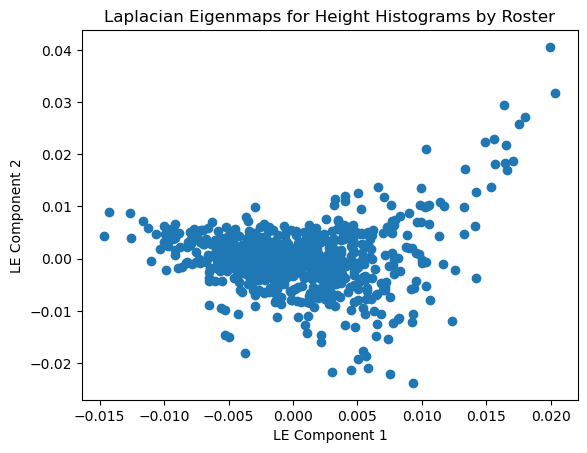

In [269]:
plt.scatter(le_df['LE_Component_1'], le_df['LE_Component_2'])
plt.title('Laplacian Eigenmaps for Height Histograms by Roster')
plt.xlabel('LE Component 1')
plt.ylabel('LE Component 2')
plt.show()

In [270]:
le_df['Season'] = list(le_df.reset_index()['Roster'].apply(lambda roster: str(roster)[:4]))
le_df['Season'] = le_df['Season'].apply(lambda season: int(season))

In [271]:
le_df

,LE_Component_1,LE_Component_2,Win_Percentage,Avg Height,Season
Roster,,,,,
2001ATL,-0.004281,-0.010545,0.304878,79.7,2001
2001BOS,-0.000786,-0.004280,0.439024,79.3,2001
2001CHH,-0.006556,-0.004190,0.560976,80.0,2001
2001CHI,0.006122,-0.003665,0.182927,78.3,2001
2001CLE,-0.000145,0.005578,0.365854,79.4,2001
...,...,...,...,...,...
2024SAC,0.004541,0.003134,0.560976,78.7,2024
2024SAS,0.001995,0.003046,0.268293,79.4,2024
2024TOR,0.008966,0.008788,0.304878,78.4,2024


In [272]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.io import output_notebook
from bokeh.models import ColorBar
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256
from bokeh.plotting import figure, show
from bokeh.models import Slider
from bokeh.layouts import column
from bokeh.io import show
from bokeh.models import Slider, CustomJS

In [119]:
# Creating a ColumnDataSource for Bokeh
source = ColumnDataSource(le_df)

# Creating the figure for the bokeh plot
p = figure(
    title = 'Laplacian Eigenmaps for Height Histograms by Roster',
    x_axis_label = 'Component 1',
    y_axis_label = 'Component 2',
    width = 800,
    height = 600,
    tools = 'pan, wheel_zoom, box_zoom, reset, save'
)

# Define a color map based on the USG% values
mapper = linear_cmap(field_name='Win_Percentage', palette=Viridis256, low=le_df['Win_Percentage'].min(), high=le_df['Win_Percentage'].max())

# Creating the scatter plot
p.scatter(
    x = 'LE_Component_1',
    y = 'LE_Component_2',
    source = source,
    size = 10,
    alpha = 0.7,
    color = mapper,
    legend_label = 'Roster Heights'
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Roster', '@Roster')
                 ]
p.add_tools(hover)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0), title='Win_Percentage')
p.add_layout(color_bar, 'right')

show(p)

In [273]:
# Creating a ColumnDataSource for Bokeh
source = ColumnDataSource(le_df)

# Creating the figure for the bokeh plot
p = figure(
    title = 'Laplacian Eigenmaps for Height Histograms by Roster',
    x_axis_label = 'Component 1',
    y_axis_label = 'Component 2',
    width = 800,
    height = 600,
    tools = 'pan, wheel_zoom, box_zoom, reset, save'
)

# Define a color map based on the USG% values
mapper = linear_cmap(field_name='Season', palette=Viridis256, low=le_df['Season'].min(), high=le_df['Season'].max())

# Creating the scatter plot
p.scatter(
    x = 'LE_Component_1',
    y = 'LE_Component_2',
    source = source,
    size = 10,
    alpha = 0.7,
    color = mapper,
    legend_label = 'Roster Heights'
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Roster', '@Roster')
                 ]
p.add_tools(hover)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0), title='Win_Percentage')
p.add_layout(color_bar, 'right')

show(p)

In [429]:
# Creating a ColumnDataSource for Bokeh
source = ColumnDataSource(le_df)

# Creating the figure for the bokeh plot
p = figure(
    title = 'Laplacian Eigenmaps for Height Histograms by Roster',
    x_axis_label = 'Component 1',
    y_axis_label = 'Component 2',
    width = 800,
    height = 600,
    tools = 'pan, wheel_zoom, box_zoom, reset, save'
)

# Define a color map based on the USG% values
mapper = linear_cmap(field_name='Avg Height', palette=Viridis256, low=le_df['Avg Height'].min(), high=le_df['Avg Height'].max())

# Creating the scatter plot
p.scatter(
    x = 'LE_Component_1',
    y = 'LE_Component_2',
    source = source,
    size = 10,
    alpha = 0.7,
    color = mapper,
    legend_label = 'Roster Heights'
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Roster', '@Roster'),
    ('Avg Height', '@{Avg Height}')
                 ]
p.add_tools(hover)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0,0), title='Avg Height (Inches)')
p.add_layout(color_bar, 'right')

show(p)

In [123]:
# Assuming 'Season' column exists in le_df and contains the season info
# Creating a ColumnDataSource for Bokeh with the full dataset
source = ColumnDataSource(le_df)

# Creating another ColumnDataSource for filtered data
filtered_source = ColumnDataSource(data=source.data)

# Calculating a padding for the axes
x_padding = (le_df['LE_Component_1'].max() - le_df['LE_Component_1'].min()) * 0.05  # 5% padding
y_padding = (le_df['LE_Component_2'].max() - le_df['LE_Component_2'].min()) * 0.05  # 5% padding

# Creating the figure for the bokeh plot
p = figure(
    title='Laplacian Eigenmaps for Height Histograms by Roster',
    x_axis_label='Component 1',
    y_axis_label='Component 2',
    width=800,
    height=600,
    tools='pan, wheel_zoom, box_zoom, reset, save',
    x_range=(le_df['LE_Component_1'].min() - x_padding, le_df['LE_Component_1'].max() + x_padding),
    y_range=(le_df['LE_Component_2'].min() - y_padding, le_df['LE_Component_2'].max() + y_padding)
)

# Define a color map based on the Win_Percentage values
mapper = linear_cmap(field_name='Win_Percentage', palette=Viridis256, low=le_df['Win_Percentage'].min(), high=le_df['Win_Percentage'].max())

# Creating the scatter plot
p.scatter(
    x='LE_Component_1',
    y='LE_Component_2',
    source=filtered_source,
    size=10,
    alpha=0.7,
    color=mapper,
    legend_label='Roster Heights'
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Roster', '@Roster'),
    ('Season', '@Season'),
    ('Win_Percentage', '@Win_Percentage{0.00}')
]
p.add_tools(hover)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0, 0), title='Win_Percentage')
p.add_layout(color_bar, 'right')

# Creating a slider for season filtering
slider = Slider(start=le_df['Season'].min(), end=le_df['Season'].max(), value=le_df['Season'].min(), step=1, title='Season')

# JavaScript callback to filter the data
callback = CustomJS(args=dict(source=source, filtered_source=filtered_source, slider=slider), code="""
    const season = slider.value;
    const data = source.data;
    const filtered_data = { LE_Component_1: [], LE_Component_2: [], Win_Percentage: [], Roster: [], Season: [] };

    for (let i = 0; i < data['Season'].length; i++) {
        if (data['Season'][i] === season) {
            filtered_data['LE_Component_1'].push(data['LE_Component_1'][i]);
            filtered_data['LE_Component_2'].push(data['LE_Component_2'][i]);
            filtered_data['Win_Percentage'].push(data['Win_Percentage'][i]);
            filtered_data['Roster'].push(data['Roster'][i]);
            filtered_data['Season'].push(data['Season'][i]);
        }
    }
    filtered_source.data = filtered_data;
    filtered_source.change.emit();
""")

slider.js_on_change('value', callback)

# Layout with the slider and the plot
layout = column(slider, p)

# Show the layout
show(layout)

In [436]:
le_df

,LE_Component_1,LE_Component_2,Win_Percentage,Season,Avg Height
Roster,,,,,
2001BOS,-0.002581,0.001565,0.439024,2001,78.72
2001CHH,-0.000490,-0.002077,0.560976,2001,79.94
2001CHI,0.000940,-0.001417,0.182927,2001,79.50
2001CLE,-0.000719,0.002141,0.365854,2001,79.50
2001DAL,-0.001786,0.000527,0.646341,2001,80.07
...,...,...,...,...,...
2024POR,0.003033,0.001151,0.256098,2024,78.39
2024SAC,0.001799,0.000651,0.560976,2024,78.17
2024SAS,-0.000490,-0.002077,0.268293,2024,79.61


In [434]:
# Assuming 'Season' column exists in le_df and contains the season info
# Creating a ColumnDataSource for Bokeh with the full dataset
source = ColumnDataSource(le_df)

# Creating another ColumnDataSource for filtered data
filtered_source = ColumnDataSource(data=source.data)

# Creating the figure for the bokeh plot
p = figure(
    title='Laplacian Eigenmaps for Height Histograms by Roster',
    x_axis_label='Component 1',
    y_axis_label='Component 2',
    width=800,
    height=600,
    tools='pan, wheel_zoom, box_zoom, reset, save'
)

# Define a color map based on the Win_Percentage values
mapper = linear_cmap(field_name='Avg Height', palette=Viridis256, low=le_df['Avg Height'].min(), high=le_df['Avg Height'].max())

# Creating the scatter plot
p.scatter(
    x='LE_Component_1',
    y='LE_Component_2',
    source=filtered_source,
    size=10,
    alpha=0.7,
    color=mapper,
    legend_label='Roster Heights'
)

# Adding the hover tool for individual players
hover = HoverTool()
hover.tooltips = [
    ('Roster', '@Roster'),
    ('Season', '@Season'),
    ('Win_Percentage', '@Win_Percentage{0.00}'),
    ('Avg Height', '@{Avg Height}')
]
p.add_tools(hover)

# Add color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8, location=(0, 0), title='Average Height (Inches)')
p.add_layout(color_bar, 'right')

# Creating a slider for season filtering
slider = Slider(start=le_df['Season'].min(), end=le_df['Season'].max(), value=le_df['Season'].min(), step=1, title='Season')

# JavaScript callback to filter the data
callback = CustomJS(args=dict(source=source, filtered_source=filtered_source, slider=slider), code="""
    const season = slider.value;
    console.log("Selected Season:", season); // Debug: Check the selected value
    const data = source.data;
    const filtered_data = { 
        LE_Component_1: [], 
        LE_Component_2: [], 
        Win_Percentage: [], 
        Roster: [], 
        Season: [], 
        Avg Height: [] 
    };

    for (let i = 0; i < data['Season'].length; i++) {
        if (data['Season'][i] === season) { // Ensure type and value match
            filtered_data['LE_Component_1'].push(data['LE_Component_1'][i]);
            filtered_data['LE_Component_2'].push(data['LE_Component_2'][i]);
            filtered_data['Win_Percentage'].push(data['Win_Percentage'][i]);
            filtered_data['Roster'].push(data['Roster'][i]);
            filtered_data['Season'].push(data['Season'][i]);
            filtered_data['Avg Height'].push(data['Avg Height'][i]);
        }
    }
    console.log("Filtered Data:", filtered_data); // Debug: Check the filtered dataset
    filtered_source.data = filtered_data;
    filtered_source.change.emit();
""");

slider.js_on_change('value', callback)

# Layout with the slider and the plot
layout = column(slider, p)

# Show the layout
show(layout)